In [1]:
# import nltk
# nltk.download('stopwords')

In [2]:
import os
import re
from functools import partial

In [3]:
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [4]:
from keras.optimizers import SGD, Adam
from keras.callbacks import (
    LearningRateScheduler, ReduceLROnPlateau, EarlyStopping,
    ModelCheckpoint, TensorBoard
)
from keras.models import Sequential
from keras.metrics import CategoricalAccuracy
from keras.losses import CategoricalCrossentropy
from keras.layers import (
    Embedding, LSTM, Bidirectional, GlobalAveragePooling1D, Dense, Dropout
)
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer

# 1. Prepare data

In [5]:
df = pd.read_csv(
    'data/covid19_tweets_dataset/Corona_NLP_train.csv',
    encoding='latin_1',
    usecols=['OriginalTweet', 'Sentiment']
)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


## Visualize data

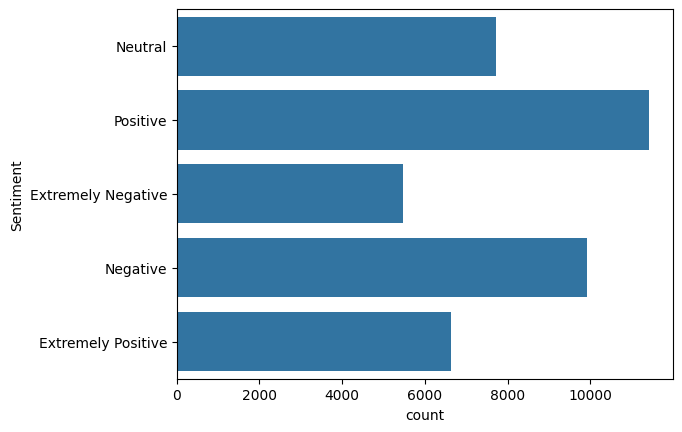

In [6]:
sns.countplot(df['Sentiment'])
plt.show()

##  Clean the text

In [7]:
def clean_string(text):
    stop_words = stopwords.words('english')

    # Convert text to lowercase
    text = text.lower()
    # Remove urls
    text = re.sub(r'http\S+', ' ', text)
    # Remove mentions
    text = re.sub(r'@\w+', ' ', text)
    # Remove hastags
    text = re.sub(r'#\w+', ' ', text)
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    # Remove html tags
    text = re.sub('r<.*?>',' ', text)
    # Remove stop_words
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    return text

In [8]:
df.OriginalTweet = df.OriginalTweet.apply(lambda x: clean_string(x))
df

,OriginalTweet,Sentiment
0,,Neutral
1,advice talk neighbours family exchange phone n...,Positive
2,coronavirus australia: woolworths give elderly...,Positive
3,"food stock one empty... please, panic, enough ...",Positive
4,"me, ready go supermarket outbreak. paranoid, f...",Extremely Negative
...,...,...
41152,airline pilots offering stock supermarket shel...,Neutral
41153,response complaint provided citing covid- rela...,Extremely Negative
41154,know itâs getting tough rationing toilet pape...,Positive
41155,wrong smell hand sanitizer starting turn on?,Neutral


## Prepare one-hot label

In [9]:
index_label_dict = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

In [10]:
def prepare_onehot_label(df, label_col_name, index_label_dict):
    # From string label to index label
    df[f'{label_col_name}_index'] = df[label_col_name].replace(index_label_dict)

    # From index label to onehot label
    to_categorical_n_classes_fn = partial(to_categorical, num_classes=len(index_label_dict))
    df[f'{label_col_name}_onehot'] = df[f'{label_col_name}_index'].apply(to_categorical_n_classes_fn)

    return df

In [11]:
df = prepare_onehot_label(df, 'Sentiment', index_label_dict)
df

/var/folders/8_/m50_8s_942q571m12vh47_q80000gq/T/ipykernel_55781/1943349255.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[f'{label_col_name}_index'] = df[label_col_name].replace(index_label_dict)


,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot
0,,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
1,advice talk neighbours family exchange phone n...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
2,coronavirus australia: woolworths give elderly...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
3,"food stock one empty... please, panic, enough ...",Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
4,"me, ready go supermarket outbreak. paranoid, f...",Extremely Negative,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...
41152,airline pilots offering stock supermarket shel...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
41153,response complaint provided citing covid- rela...,Extremely Negative,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
41154,know itâs getting tough rationing toilet pape...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
41155,wrong smell hand sanitizer starting turn on?,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"


## Split training and validation set

In [12]:
def train_test_split_by_df(df, test_size):
    # Shuffle df
    df = df.sample(frac=1, random_state=204)

    # Split train - test set
    train_df = df.iloc[:int((1 - test_size) * len(df))]
    test_df = df.iloc[int((1 - test_size) * len(df)):]

    return train_df, test_df

In [13]:
train_df, val_df = train_test_split_by_df(df, 0.2)

In [14]:
train_df

,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot
32259,staff put together update need know today,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
12637,described msm âhighly skilled politician â. ...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]"
34646,pretty sad high point day scoring toilet paper...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
10578,"came across this, supermarket, sure caught it?",Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"
9977,restaurant offers entire stock food staff clos...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...
34254,report: impact covid- consumer behavior make l...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"
32469,healthcare workers grocery store employees any...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
11415,working full time means time go shopping there...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
27332,hypermarket kavac k preparing food packets fam...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"


In [15]:
val_df

,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot
26887,supermarkets al meera consumer goods co. start...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
344,"guy taking whole stride. sensible, panicking g...",Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
26619,salvation army jackson said experiencing criti...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"
34461,one top priorities trump considering mitigatio...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]"
19347,coronavirus covid store update unfortunately d...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...,...,...
39516,one word explain,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
6682,covid - panic buying supermarket!,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"
12261,"seriously, stop panic buying. plenty supplies ...",Extremely Negative,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
19725,guarantee people moaning people going ones pan...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"


## Tokenization

In [16]:
tokenizer = Tokenizer()
tokenizer

In [17]:
tokenizer.fit_on_texts(train_df.OriginalTweet)

In [18]:
train_df['OriginalTweet_tokenized'] = tokenizer.texts_to_sequences(train_df['OriginalTweet'])
train_df

,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot,OriginalTweet_tokenized
32259,staff put together update need know today,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[57, 176, 269, 364, 13, 52, 42]"
12637,described msm âhighly skilled politician â. ...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[5871, 8599, 16283, 5489, 6362, 2009, 4861, 48..."
34646,pretty sad high point day scoring toilet paper...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[807, 1072, 113, 462, 54, 16284, 37, 38, 38, 1..."
10578,"came across this, supermarket, sure caught it?",Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[680, 178, 211, 5, 199, 1494, 130]"
9977,restaurant offers entire stock food staff clos...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[536, 922, 965, 29, 3, 57, 1846, 30, 1]"
...,...,...,...,...,...
34254,report: impact covid- consumer behavior make l...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[190, 90, 1, 9, 241, 48, 728, 787]"
32469,healthcare workers grocery store employees any...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[291, 15, 6, 4, 89, 173, 284, 259, 376, 12, 67..."
11415,working full time means time go shopping there...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[67, 152, 18, 474, 18, 20, 10, 767, 310, 261, ..."
27332,hypermarket kavac k preparing food packets fam...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[2928, 32035, 427, 2222, 3, 3994, 337, 13]"


In [19]:
val_df['OriginalTweet_tokenized'] = tokenizer.texts_to_sequences(val_df['OriginalTweet'])
val_df

,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot,OriginalTweet_tokenized
26887,supermarkets al meera consumer goods co. start...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[151, 2979, 14908, 9, 183, 943, 574, 6705, 983..."
344,"guy taking whole stride. sensible, panicking g...",Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[1139, 161, 429, 2677, 2190, 3411, 5499, 194, ..."
26619,salvation army jackson said experiencing criti...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[8022, 2159, 12888, 116, 1319, 483, 329, 3, 13..."
34461,one top priorities trump considering mitigatio...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[28, 464, 2415, 256, 1663, 9844, 3, 8, 1312, 1..."
19347,coronavirus covid store update unfortunately d...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[24, 1, 4, 364, 1578, 30, 99, 5312, 95, 1598, ..."
...,...,...,...,...,...
39516,one word explain,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[28, 1430, 2000]"
6682,covid - panic buying supermarket!,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[1, 16, 31, 5]"
12261,"seriously, stop panic buying. plenty supplies ...",Extremely Negative,0,"[1.0, 0.0, 0.0, 0.0, 0.0]","[558, 58, 16, 31, 620, 97, 529, 988, 148, 265,..."
19725,guarantee people moaning people going ones pan...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[3882, 7, 6188, 7, 27, 628, 16, 360, 603, 3, 2..."


## Pad sequence

In [20]:
train_df['OriginalTweet_tokenized_len'] = train_df.OriginalTweet_tokenized.apply(lambda x :len(x))
train_df

,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot,OriginalTweet_tokenized,OriginalTweet_tokenized_len
32259,staff put together update need know today,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[57, 176, 269, 364, 13, 52, 42]",7
12637,described msm âhighly skilled politician â. ...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[5871, 8599, 16283, 5489, 6362, 2009, 4861, 48...",21
34646,pretty sad high point day scoring toilet paper...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[807, 1072, 113, 462, 54, 16284, 37, 38, 38, 1...",19
10578,"came across this, supermarket, sure caught it?",Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[680, 178, 211, 5, 199, 1494, 130]",7
9977,restaurant offers entire stock food staff clos...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[536, 922, 965, 29, 3, 57, 1846, 30, 1]",9
...,...,...,...,...,...,...
34254,report: impact covid- consumer behavior make l...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[190, 90, 1, 9, 241, 48, 728, 787]",8
32469,healthcare workers grocery store employees any...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[291, 15, 6, 4, 89, 173, 284, 259, 376, 12, 67...",15
11415,working full time means time go shopping there...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[67, 152, 18, 474, 18, 20, 10, 767, 310, 261, ...",12
27332,hypermarket kavac k preparing food packets fam...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[2928, 32035, 427, 2222, 3, 3994, 337, 13]",8


In [21]:
max_len = np.max(train_df.OriginalTweet_tokenized_len)
max_len

43

In [22]:
np.average(train_df.OriginalTweet_tokenized_len)

16.113530751708428

In [23]:
train_df['OriginalTweet_tokenized_padded'] = list(pad_sequences(
    train_df.OriginalTweet_tokenized, maxlen=max_len, padding='post', dtype='float32'
))
train_df['OriginalTweet_tokenized_padded_len'] = train_df.OriginalTweet_tokenized_padded.apply(lambda x :len(x))
train_df

,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot,OriginalTweet_tokenized,OriginalTweet_tokenized_len,OriginalTweet_tokenized_padded,OriginalTweet_tokenized_padded_len
32259,staff put together update need know today,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[57, 176, 269, 364, 13, 52, 42]",7,"[57.0, 176.0, 269.0, 364.0, 13.0, 52.0, 42.0, ...",43
12637,described msm âhighly skilled politician â. ...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[5871, 8599, 16283, 5489, 6362, 2009, 4861, 48...",21,"[5871.0, 8599.0, 16283.0, 5489.0, 6362.0, 2009...",43
34646,pretty sad high point day scoring toilet paper...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[807, 1072, 113, 462, 54, 16284, 37, 38, 38, 1...",19,"[807.0, 1072.0, 113.0, 462.0, 54.0, 16284.0, 3...",43
10578,"came across this, supermarket, sure caught it?",Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[680, 178, 211, 5, 199, 1494, 130]",7,"[680.0, 178.0, 211.0, 5.0, 199.0, 1494.0, 130....",43
9977,restaurant offers entire stock food staff clos...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[536, 922, 965, 29, 3, 57, 1846, 30, 1]",9,"[536.0, 922.0, 965.0, 29.0, 3.0, 57.0, 1846.0,...",43
...,...,...,...,...,...,...,...,...
34254,report: impact covid- consumer behavior make l...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[190, 90, 1, 9, 241, 48, 728, 787]",8,"[190.0, 90.0, 1.0, 9.0, 241.0, 48.0, 728.0, 78...",43
32469,healthcare workers grocery store employees any...,Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[291, 15, 6, 4, 89, 173, 284, 259, 376, 12, 67...",15,"[291.0, 15.0, 6.0, 4.0, 89.0, 173.0, 284.0, 25...",43
11415,working full time means time go shopping there...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[67, 152, 18, 474, 18, 20, 10, 767, 310, 261, ...",12,"[67.0, 152.0, 18.0, 474.0, 18.0, 20.0, 10.0, 7...",43
27332,hypermarket kavac k preparing food packets fam...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[2928, 32035, 427, 2222, 3, 3994, 337, 13]",8,"[2928.0, 32035.0, 427.0, 2222.0, 3.0, 3994.0, ...",43


In [24]:
val_df['OriginalTweet_tokenized_padded'] = list(pad_sequences(
    val_df.OriginalTweet_tokenized, maxlen=max_len, padding='post', dtype='float32'
))
val_df['OriginalTweet_tokenized_padded_len'] = val_df.OriginalTweet_tokenized_padded.apply(lambda x :len(x))
val_df

,OriginalTweet,Sentiment,Sentiment_index,Sentiment_onehot,OriginalTweet_tokenized,OriginalTweet_tokenized_padded,OriginalTweet_tokenized_padded_len
26887,supermarkets al meera consumer goods co. start...,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[151, 2979, 14908, 9, 183, 943, 574, 6705, 983...","[151.0, 2979.0, 14908.0, 9.0, 183.0, 943.0, 57...",43
344,"guy taking whole stride. sensible, panicking g...",Positive,3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[1139, 161, 429, 2677, 2190, 3411, 5499, 194, ...","[1139.0, 161.0, 429.0, 2677.0, 2190.0, 3411.0,...",43
26619,salvation army jackson said experiencing criti...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[8022, 2159, 12888, 116, 1319, 483, 329, 3, 13...","[8022.0, 2159.0, 12888.0, 116.0, 1319.0, 483.0...",43
34461,one top priorities trump considering mitigatio...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[28, 464, 2415, 256, 1663, 9844, 3, 8, 1312, 1...","[28.0, 464.0, 2415.0, 256.0, 1663.0, 9844.0, 3...",43
19347,coronavirus covid store update unfortunately d...,Extremely Positive,4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[24, 1, 4, 364, 1578, 30, 99, 5312, 95, 1598, ...","[24.0, 1.0, 4.0, 364.0, 1578.0, 30.0, 99.0, 53...",43
...,...,...,...,...,...,...,...
39516,one word explain,Neutral,2,"[0.0, 0.0, 1.0, 0.0, 0.0]","[28, 1430, 2000]","[28.0, 1430.0, 2000.0, 0.0, 0.0, 0.0, 0.0, 0.0...",43
6682,covid - panic buying supermarket!,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[1, 16, 31, 5]","[1.0, 16.0, 31.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0...",43
12261,"seriously, stop panic buying. plenty supplies ...",Extremely Negative,0,"[1.0, 0.0, 0.0, 0.0, 0.0]","[558, 58, 16, 31, 620, 97, 529, 988, 148, 265,...","[558.0, 58.0, 16.0, 31.0, 620.0, 97.0, 529.0, ...",43
19725,guarantee people moaning people going ones pan...,Negative,1,"[0.0, 1.0, 0.0, 0.0, 0.0]","[3882, 7, 6188, 7, 27, 628, 16, 360, 603, 3, 2...","[3882.0, 7.0, 6188.0, 7.0, 27.0, 628.0, 16.0, ...",43


# 2. Build and train model

## Build model

In [25]:
vocab_len = len(tokenizer.word_index) + 1
num_classes = len(train_df.Sentiment.unique())

In [26]:
model = Sequential([
    Embedding(vocab_len, 32),
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dense(16, 'relu'),
    Dropout(0.2),
    Dense(num_classes, 'softmax')
])
model.build(input_shape=(vocab_len, 32))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32036, 32, 32)        │     1,025,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32036, 32, 64)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (32036, 64)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32036, 16)            │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32036, 16)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32036, 5)             │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,917 (3.98 MB)

 Trainable params: 1,042,917 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

## Compile model

In [27]:
ce_loss = CategoricalCrossentropy()

In [28]:
# # Optimizer: Stochastic Gradient Descent (SGD)
# opt = SGD(learning_rate=0.001)


# Optimizer: Adaptive Moment Estimation (Adam)
opt = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Other optimizers: AdamW, Nadam ...

In [29]:
acc = CategoricalAccuracy()

In [30]:
model.compile(loss=ce_loss, optimizer=opt, metrics=[acc])

## Train model

In [31]:
BATCH_SIZE = 512
NUM_EPOCH = 20

In [32]:
x_train = np.array([arr for arr in train_df.OriginalTweet_tokenized_padded])
y_train = np.array([arr for arr in train_df.Sentiment_onehot])
x_val = np.array([arr for arr in val_df.OriginalTweet_tokenized_padded])
y_val = np.array([arr for arr in val_df.Sentiment_onehot])

In [33]:
x_train.shape, y_train.shape

((32925, 43), (32925, 5))

In [34]:
x_val.shape, y_val.shape

((8232, 43), (8232, 5))

#### Callbacks

In [35]:
def scheduler_func(epoch, lr):
    if epoch < 3:
        return lr * 2
    elif 3 < epoch and epoch < 7:
        return lr
    else:
        return lr / 3

In [36]:
# 1. Change learning rate - LearningRateScheduler
# lr_callback = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, min_delta=0.0001
# )

lr_callback = LearningRateScheduler(scheduler_func)

In [37]:
# 2. Early stop - save training cost
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

In [38]:
# 3. Save checkpoint
os.makedirs('ckpt', exist_ok=True)
# save_weights_only = False
# => Keras saves both model architecture and weights
# => Load to empty model

# save_weights_only = True
# => Keras saves weights
# => First, init model with architecture => Second, load model

# Save each epoch with loss value
model_ckpt_callback = ModelCheckpoint(
    filepath='ckpt/checkpoint_epoch_{epoch}.weights.h5',
    save_weights_only=True,
    save_best_only=False, # True/False
#     monitor='val_accuracy'
)

In [39]:
# 4. Monitor training process - Tensorboard
tensorboard_callback = TensorBoard(log_dir='logs')

In [40]:
x_train.shape

(32925, 43)

In [41]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    validation_data=(x_val, y_val),
    shuffle=True,
    validation_batch_size=BATCH_SIZE * 2,
    callbacks=[
        lr_callback,
        early_stop_callback,
        model_ckpt_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - categorical_accuracy: 0.2697 - loss: 1.5736 - val_categorical_accuracy: 0.3977 - val_loss: 1.4083 - learning_rate: 0.0020
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - categorical_accuracy: 0.4113 - loss: 1.3274 - val_categorical_accuracy: 0.6347 - val_loss: 0.9301 - learning_rate: 0.0040
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - categorical_accuracy: 0.7165 - loss: 0.7680 - val_categorical_accuracy: 0.7289 - val_loss: 0.7280 - learning_rate: 0.0080
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - categorical_accuracy: 0.8570 - loss: 0.4659 - val_categorical_accuracy: 0.7547 - val_loss: 0.7313 - learning_rate: 0.0027
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - categorical_accuracy: 0.9042 - loss: 0.3430 - val_categorical_accuracy: 0.7529 - val_loss: 0.7909 - learning_rate: 0.0027
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - categorical_accuracy: 0.9301 - loss: 0.2677 - val_categorical_accuracy: 

# 3. Predict new data

In [42]:
# Tomorrow
loaded_model = Sequential([
    Embedding(vocab_len, 32),
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dense(16, 'relu'),
    Dropout(0.2),
    Dense(num_classes, 'softmax')
])
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
loaded_model.build(input_shape=(vocab_len, 32))

In [44]:
loaded_model.load_weights('ckpt/checkpoint_epoch_4.weights.h5')
loaded_model

<Sequential name=sequential_1, built=True>

In [45]:
pred_prob = loaded_model.predict(x_val)
pred_prob

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[4.1683216e-04, 5.8817022e-02, 9.0044212e-01, 4.0206991e-02,
        1.1714515e-04],
       [4.5563031e-02, 9.1329211e-01, 1.7275602e-02, 2.3715056e-02,
        1.5428221e-04],
       [2.2627923e-01, 7.6072448e-01, 3.1660385e-03, 9.6380338e-03,
        1.9234503e-04],
       ...,
       [8.8243073e-01, 1.1650111e-01, 1.3638422e-04, 8.8059000e-04,
        5.1140378e-05],
       [7.2451152e-02, 8.1254965e-01, 5.0387140e-02, 6.3386403e-02,
        1.2256859e-03],
       [6.7637051e-03, 2.5424007e-01, 9.4388023e-02, 6.2827301e-01,
        1.6335208e-02]], dtype=float32)

In [46]:
pred_prob.shape

(8232, 5)

In [47]:
pred_class = np.argmax(pred_prob, axis=1)
pred_class

array([2, 1, 1, ..., 0, 1, 3])

In [48]:
print(classification_report(val_df.Sentiment_index, pred_class))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73      1110
           1       0.65      0.75      0.70      1955
           2       0.85      0.79      0.82      1547
           3       0.72      0.79      0.75      2291
           4       0.88      0.73      0.80      1329

    accuracy                           0.75      8232
   macro avg       0.78      0.74      0.76      8232
weighted avg       0.77      0.75      0.76      8232

